In [1]:
### 1. ENVIRONMENT SETUP & DEPENDENCIES
# Install the CatBoost framework and import core libraries for signal processing, physics calculations, and machine learning.
!pip install catboost
import os
import shutil
import zipfile
import glob
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Signal Processing
from scipy.signal import find_peaks, welch
from scipy.interpolate import interp1d
from scipy.stats import skew, kurtosis, entropy
# Machine Learning Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
# Classifiers
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [2]:
### 2. CONFIGURATION & BIOMETRIC METADATA
# Define subject metadata (height, gender) and shot  labels.
SUBJECT_DATA = {
    'Nouran': [177, 'Female'], 'Sohaila': [164, 'Female'], 'Menna': [159, 'Female'],
    'Bahaa': [196, 'Male'], 'Abdelrahmn': [178, 'Male'], 'Mahmoud': [176, 'Male'],
    'Sami': [179, 'Male'], 'Mazen': [165, 'Male'], 'Omar_sherif': [182, 'Male'],
    'Omar_Abouelela': [174, 'Male'], 'Mohamed_Khaled': [174, 'Male']
}
LABEL_MAP = {
    'under': "The Paint",
    'foul': "The Free Throw Line",
    '3_point': "The 3-Point Zone", '3 point': "The 3-Point Zone", '3 points': "The 3-Point Zone", '3_points': "The 3-Point Zone"
}

TARGET_FREQ = 50
# SEC_BEFORE = 1.0: 1 second allows us to capture the "set point" or wind-up of the shot.
SEC_BEFORE = 1.0
# SEC_AFTER = 2.0: 2 seconds ensures we capture the release and the follow-through of the arm.
SEC_AFTER = 2.0
# WINDOW CALCULATION: Converts seconds to array indices (e.g., 1.0 * 50 = 50 samples)
WINDOW_BEFORE = int(SEC_BEFORE * TARGET_FREQ)
WINDOW_AFTER = int(SEC_AFTER * TARGET_FREQ)
TOTAL_WINDOW = WINDOW_BEFORE + WINDOW_AFTER
# SHOT_THRESHOLD = 11.5: Gravity is 9.8 m/s². Standing still is ~9.8.
SHOT_THRESHOLD = 11.5 # Needed for peak detection
SAMPLING_RATE = 50.0 # Needed for Jerk calculation

In [3]:
### 3. RECURSIVE DATA EXTRACTION ENGINE
# Mount Google Drive and utilize zipfile logic to recursively extract nested sensor logs into a temporary processing directory.
from google.colab import drive
drive.mount('/content/drive')

extract_root = "/content/dataset_extracted"
zip_path = "/content/drive/MyDrive/Data ML.zip"

print(f"\n   Extracting: {zip_path}")
if os.path.exists(extract_root): shutil.rmtree(extract_root)
os.makedirs(extract_root)

if os.path.exists(zip_path):
    outer_extract = "/content/temp_outer"
    if os.path.exists(outer_extract): shutil.rmtree(outer_extract)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(outer_extract)
    for z in glob.glob(os.path.join(outer_extract, "**", "*.zip"), recursive=True):
        try:
            target_dir = os.path.join(extract_root, os.path.splitext(os.path.basename(z))[0])
            os.makedirs(target_dir, exist_ok=True)
            with zipfile.ZipFile(z, 'r') as zref:
                zref.extractall(target_dir)
        except: pass

Mounted at /content/drive

   Extracting: /content/drive/MyDrive/Data ML.zip


 Found File: Orientation.csv
 Path: /content/dataset_extracted/Omar_sherif_-_3_points-2025-12-22_10-33-09
 Raw Columns: ['time', 'seconds_elapsed', 'qz', 'qy', 'qx', 'qw', 'roll', 'pitch', 'yaw']
----------------------------------------
 Scanning Sampling Frequencies in: /content/dataset_extracted...


 SAMPLING RATE REPORT (33 files)
   Minimum: 53.24 Hz
   Maximum: 60.84 Hz
   Average: 55.99 Hz
   Median:  53.24 Hz


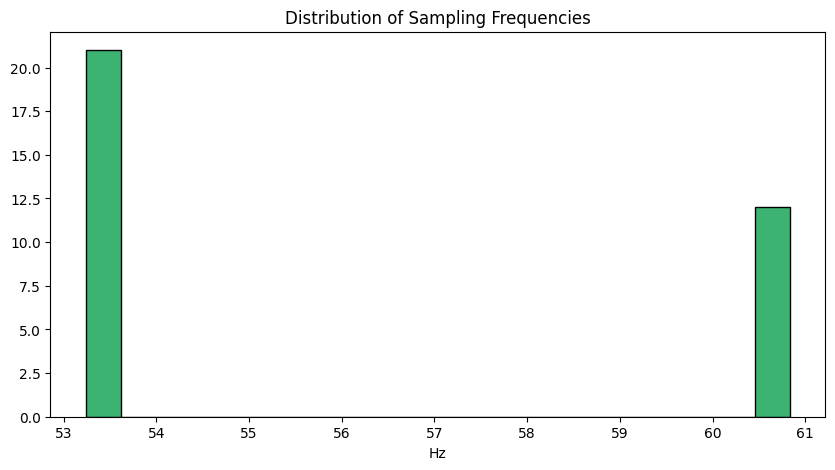

In [4]:
### 4. REAL-TIME SAMPLING RATE CALCULATION
#Scan the raw dataset and calculate the actual hardware sampling frequency by measuring the median time gap (seconds_elapsed) between timestamps. This validates that the sensors are delivering the expected 50Hz–60Hz performance before resampling.
found = False
for root, dirs, files in os.walk(extract_root):
    for f in files:
        if f.endswith(".csv") and "meta" not in f:  # Ignore metadata files if any
            full_path = os.path.join(root, f)

            try:
                # Read just the first row to get headers
                df_peek = pd.read_csv(full_path, nrows=2)

                print(f" Found File: {f}")
                print(f" Path: {root}")
                print(f" Raw Columns: {list(df_peek.columns)}")
                print("-" * 40)

                found = True
                break # Stop after finding the first one to avoid spamming
            except:
                pass
    if found: break


extract_root = "/content/dataset_extracted"
print(f" Scanning Sampling Frequencies in: {extract_root}...\n")

all_freqs = []
file_details = []

for root, dirs, files in os.walk(extract_root):
    # 1. Select the file
    target_file = None
    if "TotalAcceleration.csv" in files:
        target_file = "TotalAcceleration.csv"
    elif "accelerometer.csv" in files:
        target_file = "accelerometer.csv"

    if target_file:
        full_path = os.path.join(root, target_file)
        try:
            df = pd.read_csv(full_path)

            # 2. INTELLIGENT COLUMN SELECTION
            # We strictly prioritize 'seconds_elapsed' because we know it works.
            if 'seconds_elapsed' in df.columns:
                time_col = 'seconds_elapsed'
            elif 'timestamp' in df.columns:
                time_col = 'timestamp'
            elif 'time' in df.columns:
                time_col = 'time'
            else:
                continue # Skip if no time column

            # 3. Calculate Gap
            time_diffs = df[time_col].diff().dropna()
            avg_gap = time_diffs.median()

            # 4. SANITY CHECK (Nanoseconds vs Seconds)
            # If the gap is huge (> 1000), it's likely Nanoseconds.
            if avg_gap > 1000:
                avg_gap = avg_gap / 1e9  # Convert ns to seconds

            # If gap is zero, skip
            if avg_gap > 0:
                fs = 1.0 / avg_gap
                all_freqs.append(fs)
                file_details.append((os.path.basename(root), fs, time_col))

        except Exception as e:
            pass # Skip corrupt files

# --- REPORT ---
if len(all_freqs) > 0:
    all_freqs = np.array(all_freqs)

    print("\n" + "="*40)
    print(f" SAMPLING RATE REPORT ({len(all_freqs)} files)")
    print("="*40)
    print(f"   Minimum: {np.min(all_freqs):.2f} Hz")
    print(f"   Maximum: {np.max(all_freqs):.2f} Hz")
    print(f"   Average: {np.mean(all_freqs):.2f} Hz")
    print(f"   Median:  {np.median(all_freqs):.2f} Hz")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.hist(all_freqs, bins=20, color='mediumseagreen', edgecolor='black')
    plt.title("Distribution of Sampling Frequencies")
    plt.xlabel("Hz")
    plt.show()

In [5]:
### 5. COORDINATE TRANSFORMATION (QUATERNION ROTATION)
# Transform local sensor acceleration into a global Earth-fixed frame. This uses orientation quaternions to isolate the earth_acc_z component, capturing pure vertical lift energy.
# --- 3. PHYSICS ENGINE (Updated for Roll/Pitch/Yaw) ---
def rotate_acceleration(df):
    """
    Aligns sensor data to Earth Frame using Quaternions.
    If only Roll/Pitch/Yaw exist, it converts them to Quaternions first.
    """
    # 1. Handle Pitch (Priority: Existing Column > Calculation)
    if 'ori_pitch' in df.columns:
        df['pitch'] = df['ori_pitch']
    else:
        # Placeholder, will try to calc later
        df['pitch'] = 0

    # 2. Check for Quaternions (x, y, z, w)
    quat_cols = ['ori_x', 'ori_y', 'ori_z', 'ori_w']
    has_quats = all(c in df.columns for c in quat_cols)

    # 3. If missing Quats, try to generate them from Euler (Roll/Pitch/Yaw)
    if not has_quats:
        euler_cols = ['ori_roll', 'ori_pitch', 'ori_yaw']
        if all(c in df.columns for c in euler_cols):
            # Convert Euler to Quaternion (Assuming Radians)
            # If your data is in Degrees, un-comment the next line:
            # df[euler_cols] = np.radians(df[euler_cols])

            cy = np.cos(df['ori_yaw'] * 0.5)
            sy = np.sin(df['ori_yaw'] * 0.5)
            cp = np.cos(df['ori_pitch'] * 0.5)
            sp = np.sin(df['ori_pitch'] * 0.5)
            cr = np.cos(df['ori_roll'] * 0.5)
            sr = np.sin(df['ori_roll'] * 0.5)

            df['ori_w'] = cr * cp * cy + sr * sp * sy
            df['ori_x'] = sr * cp * cy - cr * sp * sy
            df['ori_y'] = cr * sp * cy + sr * cp * sy
            df['ori_z'] = cr * cp * sy - sr * sp * cy
            has_quats = True

    # 4. Perform Rotation (If we have Quaternions now)
    if has_quats:
        ax, ay, az = df['acc_x'], df['acc_y'], df['acc_z']
        qx, qy, qz, qw = df['ori_x'], df['ori_y'], df['ori_z'], df['ori_w']

        # Standard Quaternion Rotation
        ix = qw * ax + qy * az - qz * ay
        iy = qw * ay + qz * ax - qx * az
        iz = qw * az + qx * ay - qy * ax
        iw = -qx * ax - qy * ay - qz * az

        df['earth_acc_x'] = ix * qw + iw * -qx + iy * -qz - iz * -qy
        df['earth_acc_y'] = iy * qw + iw * -qy + iz * -qx - ix * -qz
        df['earth_acc_z'] = iz * qw + iw * -qz + ix * -qy - iy * -qx

        # Recalculate pitch from Quats ONLY if it was missing
        if 'ori_pitch' not in df.columns:
            sin_p = 2 * (qw * qy - qz * qx)
            sin_p = np.clip(sin_p, -1.0, 1.0)
            df['pitch'] = np.arcsin(sin_p)

    else:
        # Fallback: No Rotation possible
        df['earth_acc_x'] = df['acc_x']
        df['earth_acc_y'] = df['acc_y']
        df['earth_acc_z'] = df['acc_z']

    return df

In [6]:
### 6. SENSOR FUSION & TEMPORAL ALIGNMENT
# Synchronize varied sensor streams (Accelerometer, Gyro, Gravity) using merge_asof. Implements linear interpolation to handle hardware jitter and create a continuous signal.
def load_recording(recording_folder):
    sensor_config = {
        'acc': ['TotalAcceleration.csv', 'accelerometer.csv'],
        'gyro': ['gyroscopeuncalibrated.csv', 'gyroscope.csv'],
        'grav': ['gravity.csv'],
        'ori': ['orientation.csv']
    }

    merged_df = None
    actual_files = {f.lower(): f for f in os.listdir(recording_folder)}

    for s_type, options in sensor_config.items():
        valid_df = None
        for opt in options:
            if opt in actual_files:
                path = os.path.join(recording_folder, actual_files[opt])
                if os.stat(path).st_size > 0:
                    try:
                        df = pd.read_csv(path)
                        df.drop_duplicates(inplace=True) # Drop duplicates: Sensors sometimes log the same millisecond twice.
                        valid_df = df
                        break
                    except: continue

        if valid_df is not None:
            rename_map = {}
            keep_cols = ['seconds_elapsed']
            for c in valid_df.columns:
                c_low = c.lower()
                if 'seconds' in c_low: continue
                suffix = ''
                if 'z' in c_low: suffix = '_z'
                elif 'y' in c_low: suffix = '_y'
                elif 'x' in c_low: suffix = '_x'
                elif 'q' in c_low: suffix = f'_q{c_low[-1]}'
                elif 'w' in c_low or 'scalar' in c_low: suffix = '_w' # quaternion scalar
                elif 'roll' in c_low: suffix = '_roll'
                elif 'pitch' in c_low: suffix = '_pitch'
                elif 'yaw' in c_low: suffix = '_yaw'
                if suffix:
                    rename_map[c] = f'{s_type}{suffix}'
                    keep_cols.append(c)

            valid_df = valid_df[keep_cols].rename(columns=rename_map)
            valid_df = valid_df.loc[:, ~valid_df.columns.duplicated()]
            if merged_df is None:
                merged_df = valid_df
            else:
                merged_df = pd.merge_asof(
                    merged_df.sort_values('seconds_elapsed'),
                    valid_df.sort_values('seconds_elapsed'),
                    on='seconds_elapsed', direction='nearest'
                )

    if merged_df is not None:
        merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
        merged_df = merged_df.fillna(0)
        merged_df = rotate_acceleration(merged_df)
        try:
            # 1Hz Fix: Linear Interpolation connects the dots to create a smooth wave.
            max_time = merged_df['seconds_elapsed'].max()
            new_time = np.arange(0, max_time, 1/TARGET_FREQ)
            new_df = pd.DataFrame({'seconds_elapsed': new_time})
            for col in merged_df.columns:
                if col == 'seconds_elapsed': continue
                f = interp1d(merged_df['seconds_elapsed'], merged_df[col], kind='linear', fill_value="extrapolate")
                new_df[col] = f(new_time)
            merged_df = new_df
        except: pass

        merged_df['mag'] = np.sqrt(merged_df['acc_x']**2 + merged_df['acc_y']**2 + merged_df['acc_z']**2)
        return merged_df
    return None

In [7]:
### 7. BIOMECHANICAL FEATURE EXTRACTION
# Calculate personalized metrics including the Effort Ratio (force normalized by height/gender), Jerk (smoothness), and Spectral Entropy to capture the "rhythm" of the shot.
# --- Helper Function: Shannon Entropy ---
def get_shannon_entropy(signal):
    counts, _ = np.histogram(signal, bins=10, density=True)
    p = counts[counts > 0]
    return entropy(p)

# --- Helper Function: Spectral Entropy ---
def get_spectral_entropy(signal, fs=100):
    fft_vals = np.abs(np.fft.rfft(signal))**2
    psd_norm = fft_vals / np.sum(fft_vals)
    psd_norm = psd_norm[psd_norm > 0]
    return entropy(psd_norm)

# --- Helper Function: Dominant Frequency ---
def get_dominant_frequency(signal, fs=100):
    fft_vals = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    max_idx = np.argmax(np.abs(fft_vals))
    return freqs[max_idx]



def get_features(window, h, g_text):
    feats = {}

    # Find peak index for stability calculation (assuming peak acceleration is the shot)
    if 'earth_acc_z' in window.columns:
        peak_idx = np.argmax(window['earth_acc_z'].values)
    elif 'acc_z' in window.columns:
        peak_idx = np.argmax(window['acc_z'].values)
    else:
        peak_idx = 0

    # 1. Calculate Expected Peak (The "Biomechanics" Benchmark)
    g_val = 1 if g_text == 'Male' else 0
    expected_peak = 12.0 + 0.05 * (h - 170.0) + 2.0 * g_val

    feats['Player_Expected_Peak'] = expected_peak

    # 2. Calculate Effort Ratio (How hard did they try relative to their body?)
    if 'mag' in window.columns:
        actual_peak = window['mag'].max()
        feats['Effort_Ratio'] = actual_peak / (expected_peak + 1e-6)

    # --- B. ENERGY & FORCE ---
    if 'earth_acc_z' in window.columns:
        # Vertical Energy (Subtract gravity roughly 9.8 for dynamic component or take abs)
        z_energy = np.sum(np.abs(window['earth_acc_z']))
        feats['Vertical Lift Energy'] = z_energy
        feats['Normalized Lift Force'] = z_energy / h

        xy_energy = np.sum(np.sqrt(window['earth_acc_x']**2 + window['earth_acc_y']**2))
        feats['Horizontal Drive Energy'] = xy_energy

        # Jerk (Smoothness)
        acc_mag = np.linalg.norm(window[['earth_acc_x', 'earth_acc_y', 'earth_acc_z']].values, axis=1)
        jerk = np.diff(acc_mag) * SAMPLING_RATE
        feats['Avg Smoothness (Jerk)'] = np.mean(np.abs(jerk))

    # --- C. MECHANICS (GYRO) ---
    if 'gyro_x' in window.columns:
        gyro_mag = np.linalg.norm(window[['gyro_x', 'gyro_y', 'gyro_z']].values, axis=1)
        feats['Avg Forearm Speed'] = np.mean(gyro_mag)
        feats['Wrist Flick Intensity'] = window['gyro_x'].max()

        # Entropy
        hist_counts, _ = np.histogram(gyro_mag, bins=10, density=True)
        feats['Motion Entropy'] = entropy(hist_counts + 1e-10)

        # Stability (Pre-shot)
        # Check to ensure peak_idx is valid for slicing
        if peak_idx > 5:
            set_phase = window.iloc[:peak_idx]
            feats['Pre-Shot Stability'] = set_phase['gyro_y'].std()
        else:
            feats['Pre-Shot Stability'] = 0.0

    # --- D. ANGLES ---
    if 'pitch' in window.columns:
        feats['Release Angle'] = window.iloc[peak_idx]['pitch']


    cols = [c for c in window.columns if c not in ['seconds_elapsed', 'mag']]
    for c in cols:
        raw = window[c].values
        # 1. Time-Domain Stats
        feats[f'{c}_mean']   = np.mean(raw)
        feats[f'{c}_std']    = np.std(raw, ddof=1) if len(raw) > 1 else 0.0
        feats[f'{c}_max']    = np.max(raw)
        feats[f'{c}_min']    = np.min(raw)
        feats[f'{c}_range']  = feats[f'{c}_max'] - feats[f'{c}_min']
        feats[f'{c}_rms']    = np.sqrt(np.mean(raw**2))      # RMS (Root Mean Square)
        feats[f'{c}_energy'] = np.sum(raw**2)                # Energy
        feats[f'{c}_skew']   = skew(raw)                     # Skewness
        feats[f'{c}_kurt']   = kurtosis(raw)                 # Kurtosis

        # 2. Frequency-Domain Stats (using your helper functions)
        feats[f'{c}_ent']      = get_shannon_entropy(raw)           # Entropy
        feats[f'{c}_spec_ent'] = get_spectral_entropy(raw, fs=SAMPLING_RATE)   # Spectral Entropy
        feats[f'{c}_dom_freq'] = get_dominant_frequency(raw, fs=SAMPLING_RATE) # Dominant Frequency

    # --- D. GLOBAL MAGNITUDE STATS ---
    if 'mag' in window.columns:
        feats['mag_max']    = window['mag'].max()
        feats['mag_mean']   = window['mag'].mean()
        feats['mag_energy'] = np.sum(window['mag']**2)

    return feats

In [8]:
### 8. ADAPTIVE PEAK SEGMENTATION
# Iterate through the dataset using a custom physics equation: Base (10.5G) + Gender Bonus - Height Adjustment. This identifies individual shots based on the player’s unique explosive power.
X_data = []
y_data = []

print("\n   SCANNING WITH ADAPTIVE BIOMECHANICS...")

for root, dirs, files in os.walk(extract_root):
    folder = os.path.basename(root)
    name_key = next((k for k in SUBJECT_DATA if k.lower() in folder.lower()), None)
    label_val = next((v for k, v in LABEL_MAP.items() if k in folder.lower()), None)

    if name_key and label_val is not None:
        df = load_recording(root)
        if df is None or len(df) < TOTAL_WINDOW: continue

        height_val, gender_val = SUBJECT_DATA[name_key]
        df = df.drop(columns=['seconds_elapsed'], errors='ignore')
        # --- THE PHYSICS EQUATION ---
        # 1. Base Threshold = 10.5 (Gravity + Minimal Effort)
        # 2. Add 1.5G if Male (More explosive power)
        # 3. Subtract 0.02G for every cm of height (Taller = Less Force Needed)
        # This creates a custom threshold for every single player!

        base_thresh = 10.5
        gender_bonus = 1.5 if gender_val == 'Male' else 0.0
        # Normalizing height around 170cm: (Height - 170) * -0.01
        # Example: 190cm player -> (20 * -0.01) = -0.2 (Lower threshold)
        height_adj = (height_val - 170) * -0.01

        PERSONAL_THRESHOLD = base_thresh + gender_bonus + height_adj

        # Safety Check: Never go below 10.0 or above 13.0
        PERSONAL_THRESHOLD = max(10.0, min(PERSONAL_THRESHOLD, 13.0))

        peaks, _ = find_peaks(df['mag'], height=PERSONAL_THRESHOLD, distance=30, prominence=2)

        if len(peaks) > 10:
            peak_heights = df['mag'].iloc[peaks].values
            top_10_indices = np.argsort(peak_heights)[-10:]
            top_10_indices = np.sort(top_10_indices)
            peaks = peaks[top_10_indices]

        for p in peaks:
            start = p - WINDOW_BEFORE
            end = p + WINDOW_AFTER
            if start < 0 or end > len(df): continue

            shot_window = df.iloc[start:end]
            ft = get_features(shot_window, height_val, gender_val)

            # --- REPORT COLUMNS ---
            ft['Subject'] = name_key
            ft['Gender'] = gender_val
            ft['Height'] = height_val
            ft['Label'] = label_val

            X_data.append(ft)
            y_data.append(label_val)

X = pd.DataFrame(X_data)
y = np.array(y_data)

print(f"\n   DATASET BUILT. Total Shots: {len(X)}")


   SCANNING WITH ADAPTIVE BIOMECHANICS...

   DATASET BUILT. Total Shots: 330



 Searching for the 'Weakest' Valid Paint Shot (Above Noise Threshold)...


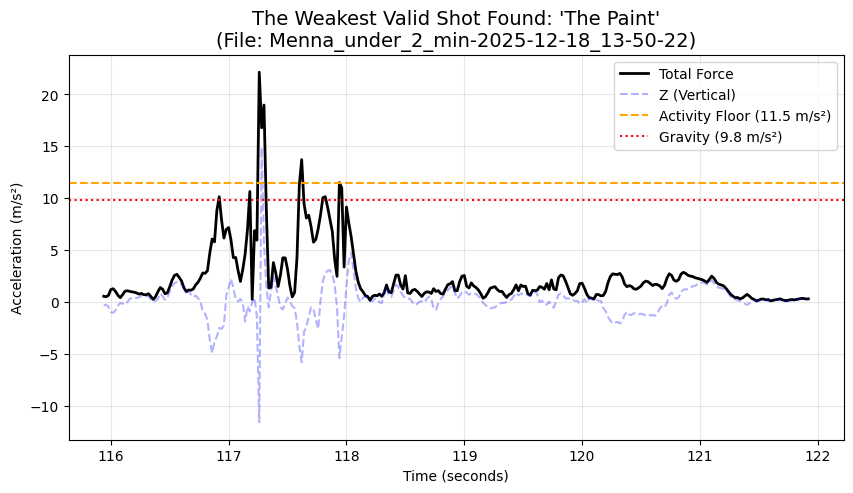

 Found lowest VALID peak: 11.50 m/s²


In [9]:
### 9. EXPLORATORY ANALYSIS: SHOT MORPHOLOGY
# Visualize the "Weakest Valid Shot" (The Paint) to verify that the peak detection floor (11.5 m/s²) is correctly filtering noise while capturing soft shooting motions.
def plot_weakest_paint_shot():
    print("\n Searching for the 'Weakest' Valid Paint Shot (Above Noise Threshold)...")

    lowest_peak_val = float('inf')
    best_window = None
    best_subject = ""

    # --- BIOMECHANICS FLOOR ---
    # Gravity is 9.8. Standing/Walking is ~10-11.
    # A real shot (even a soft one) usually spikes above 11.5 m/s².
    HUMAN_ACTIVITY_FLOOR = 11.5

    # 1. Scan folders for 'under' (The Paint)
    for root, dirs, files in os.walk(extract_root):
        if 'under' in os.path.basename(root).lower():

            # 2. Load the file
            df = load_recording(root)
            if df is None: continue

            # 3. Find Peaks
            # height=HUMAN_ACTIVITY_FLOOR: Ignores walking/standing noise
            peaks, _ = find_peaks(df['mag'], height=HUMAN_ACTIVITY_FLOOR, distance=30, prominence=2.0)

            if len(peaks) == 0: continue

            # 4. Find the SMALLEST peak in this file
            # Get the heights of all valid peaks
            peak_heights = df['mag'].iloc[peaks].values

            # Find the minimum among them
            min_idx_local = np.argmin(peak_heights)
            file_min_peak_val = peak_heights[min_idx_local]
            file_min_peak_idx = peaks[min_idx_local]

            # 5. Is this the global lowest VALID shot so far?
            if file_min_peak_val < lowest_peak_val:
                lowest_peak_val = file_min_peak_val

                # Extract the 3-second window
                start = max(0, file_min_peak_idx - 100)
                end = min(len(df), file_min_peak_idx + 200)
                best_window = df.iloc[start:end].copy()
                best_subject = os.path.basename(root)

    # 6. Plot the Result
    if best_window is not None:
        plt.figure(figsize=(10, 5))

        # Plot Magnitude
        plt.plot(best_window['seconds_elapsed'], best_window['mag'],
                 label='Total Force', color='black', linewidth=2)

        # Plot Components (faint)
        plt.plot(best_window['seconds_elapsed'], best_window['acc_z'],
                 label='Z (Vertical)', color='blue', alpha=0.3, linestyle='--')

        plt.title(f"The Weakest Valid Shot Found: 'The Paint'\n(File: {best_subject})", fontsize=14)
        plt.xlabel("Time (seconds)")
        plt.ylabel("Acceleration (m/s²)")

        # Draw the Floor Line to show what we filtered out
        plt.axhline(y=HUMAN_ACTIVITY_FLOOR, color='orange', linestyle='--', label='Activity Floor (11.5 m/s²)')
        plt.axhline(y=9.8, color='r', linestyle=':', label='Gravity (9.8 m/s²)')

        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        print(f" Found lowest VALID peak: {lowest_peak_val:.2f} m/s²")
plot_weakest_paint_shot()

In [10]:
### 10. DATA CLEANING & NESTED ARRAY REFINEMENT
# Reorders columns to prioritize biometric inputs and implements the clean_nested_cell function to average residual arrays, ensuring every feature is a 1-dimensional numeric scalar.

# Reorder Columns
cols = ['Subject', 'Gender', 'Height'] + \
       [c for c in X.columns if c not in ['Subject', 'Gender', 'Height', 'Label']] + \
       ['Label']
X = X[cols]

def clean_nested_cell(val):
    # If the cell contains a Series/List/Array, average it to a single number
    if isinstance(val, (pd.Series, np.ndarray, list)):
        return np.mean(val)
    return val

# Identify sensor columns (exclude the text columns)
sensor_cols = [c for c in X.columns if c not in ['Subject', 'Gender', 'Label']]
for col in sensor_cols:
    # Only fix if the column looks like 'object' (which implies mixed data)
    if X[col].dtype == 'object':
        X[col] = X[col].apply(clean_nested_cell)
        # Force back to numbers
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

In [11]:
### 11. DATA INTEGRITY & ARCHITECTURE VALIDATION
# Performs a final scan of the dataset shape, data types (X.info()), and missing values to guarantee a high-quality matrix before entering the machine learning engine.
from IPython.display import display
print("\n=== 1. Table ===")
display(X)

print("\n=== 2. SHAPE (Rows, Columns) ===")
print(X.shape)

print("\n=== 3. INFO (Data Types) ===")
X.info()

print("\n=== 4. MISSING VALUES ===")
nulls = X.isnull().sum()
problems = nulls[nulls > 0]
if problems.empty:
    print("No missing values found in any column.")
else:
    print("Found missing values in these columns:")
    print(problems)

print("\n=== 5. DUPLICATES ===")
print(X.duplicated().sum())

print("\n=== 6. Balanced classes ===")
X['Label'].value_counts()


=== 1. Table ===


,Subject,Gender,Height,Player_Expected_Peak,Effort_Ratio,Vertical Lift Energy,Normalized Lift Force,Horizontal Drive Energy,Avg Smoothness (Jerk),Avg Forearm Speed,...,earth_acc_z_energy,earth_acc_z_skew,earth_acc_z_kurt,earth_acc_z_ent,earth_acc_z_spec_ent,earth_acc_z_dom_freq,mag_max,mag_mean,mag_energy,Label
0,Omar_sherif,Male,182,14.6,6.010673,585.359384,3.216260,992.897846,121.913833,3.160745,...,9276.149737,-2.823196,13.928684,1.255753,3.291205,1.333333,87.755831,8.171688,35617.688636,The 3-Point Zone
1,Omar_sherif,Male,182,14.6,4.845134,605.838118,3.328781,887.853168,82.720251,2.625460,...,9006.615248,-2.412207,10.799835,1.226162,2.871717,1.333333,70.738964,7.618456,27216.038503,The 3-Point Zone
2,Omar_sherif,Male,182,14.6,5.488664,530.335581,2.913932,1052.877985,99.858605,2.969504,...,8881.126393,-2.975940,15.051539,0.895801,2.980886,1.333333,80.134494,8.256523,32728.667142,The 3-Point Zone
3,Omar_sherif,Male,182,14.6,5.980021,565.205880,3.105527,1026.777304,104.601747,2.935578,...,8866.945803,-3.483399,19.239381,1.228457,3.033713,1.333333,87.308315,8.124709,32073.862038,The 3-Point Zone
4,Omar_sherif,Male,182,14.6,5.035268,598.634887,3.289203,986.422421,90.762153,2.904418,...,9551.950746,-2.931411,13.736605,1.118594,3.077561,1.333333,73.514922,8.065436,29419.708353,The 3-Point Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,Mohamed_Khaled,Male,174,14.2,3.785382,430.110765,2.471901,1344.290911,128.392534,4.347896,...,2922.819113,-0.848302,6.018611,1.425513,3.205041,1.333333,53.752427,9.854598,32124.748970,The 3-Point Zone
326,Mohamed_Khaled,Male,174,14.2,5.695655,390.776430,2.245842,1450.369786,171.339684,4.100199,...,3720.540142,-2.115358,12.037237,1.175246,3.883521,1.333333,80.878303,10.325103,42211.054596,The 3-Point Zone
327,Mohamed_Khaled,Male,174,14.2,5.660584,418.111208,2.402938,1407.136955,176.750166,4.118597,...,4960.962921,-3.501620,20.341827,0.982644,3.714038,1.666667,80.380303,10.086450,38747.521270,The 3-Point Zone
328,Mohamed_Khaled,Male,174,14.2,5.098580,311.551594,1.790526,1286.561061,172.111134,3.224984,...,2628.385971,0.528106,14.932159,1.146577,3.872641,1.666667,72.399835,9.066574,34541.645939,The 3-Point Zone



=== 2. SHAPE (Rows, Columns) ===
(330, 246)

=== 3. INFO (Data Types) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Columns: 246 entries, Subject to Label
dtypes: float64(242), int64(1), object(3)
memory usage: 634.3+ KB

=== 4. MISSING VALUES ===
No missing values found in any column.

=== 5. DUPLICATES ===
0

=== 6. Balanced classes ===


,count
Label,
The 3-Point Zone,110
The Paint,110
The Free Throw Line,110


In [12]:
### 12. CATEGORICAL ENCODING & STRATIFIED TRAIN-TEST SPLIT
# Encodes categorical "Gender" data into numeric format and utilizes an 80/20 stratified split to ensure that training and testing sets maintain an identical balance of shot labels.

# 1. Encode Gender (Automated)
print("\n   ENCODING GENDER (Female->0, Male->1)...")
le = LabelEncoder()
X['Gender'] = le.fit_transform(X['Gender'])

# 2. Encode Target Labels (CRITICAL FIX FOR XGBOOST)
# We turn "The Paint" -> 0, "Foul" -> 1, etc.
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# 3. Split: 80% Training, 20% Testing.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=X['Label'], random_state=42)

# 4. SAVE NAMES & LABELS
test_ids = X_test['Subject'].values
test_labels = X_test['Label'].values

# 5. DROP TEXT COLUMNS
X_train = X_train.drop(['Subject', 'Label'], axis=1)
X_test = X_test.drop(['Subject', 'Label'], axis=1)


   ENCODING GENDER (Female->0, Male->1)...


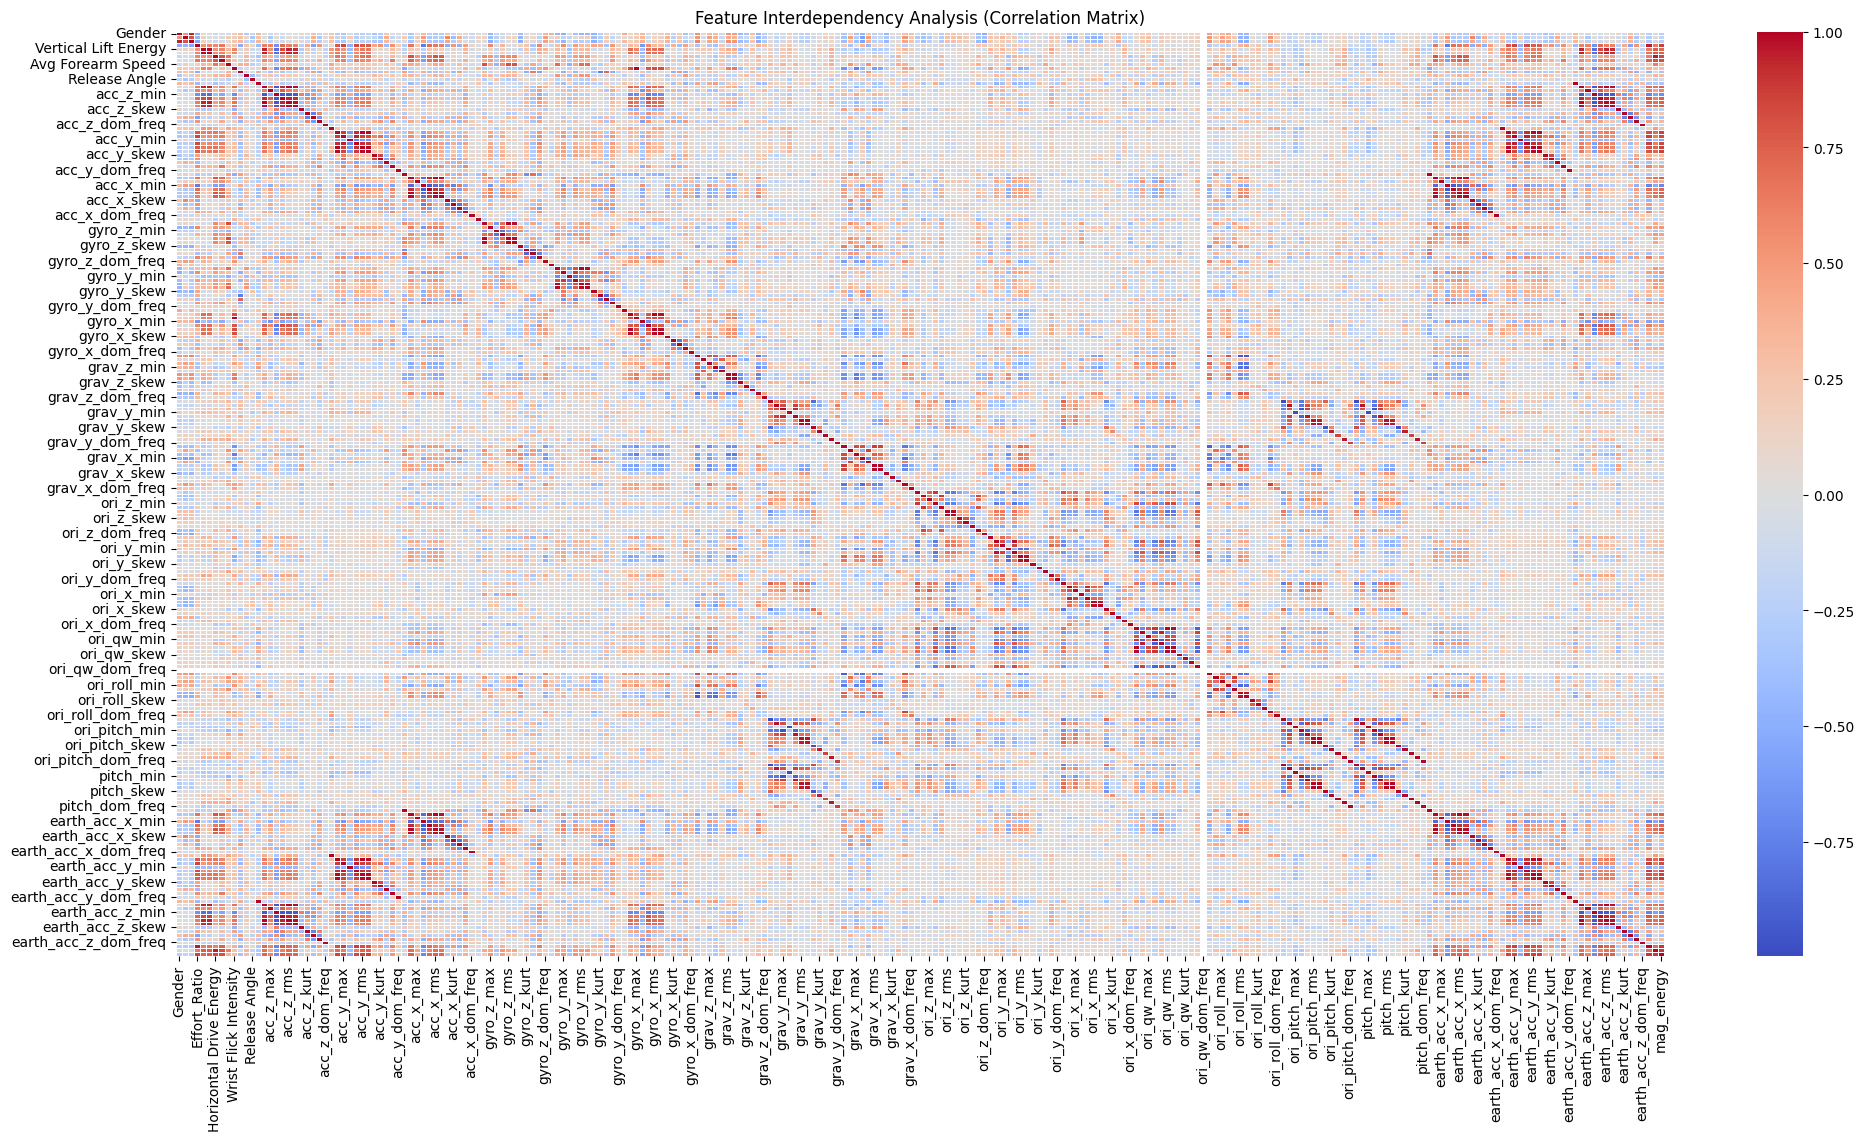

In [13]:
### 13. FEATURE CORRELATION & MULTICOLLINEARITY SCAN
# Generates a high-resolution heatmap to identify dependencies between sensor axes, ensuring features provide unique predictive value.

plt.figure(figsize=(24, 12))
corr_matrix = X.select_dtypes(include=[np.number]).corr()

sns.heatmap(
    corr_matrix,
    annot=False,       # Set to True if you have few features and want to see numbers
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)

plt.title("Feature Interdependency Analysis (Correlation Matrix)")
plt.show()

In [14]:
### 14. FEATURE STANDARDIZATION & DIMENSIONALITY REDUCTION (PCA)
# Applies StandardScaler to normalize varied biometric and sensor units (e.g., Height vs. Acceleration),
# followed by PCA to retain 95% of total signal variance. This processes 80+ features into approximately 19 significant components, preventing scale-bias and filtering out experimental noise to optimize model training.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("   APPLYING PCA (Keeping 95% Variance)...")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"    Features compressed: {X_train_scaled.shape[1]} -> {X_train_pca.shape[1]}")

print("\n=== 1. Table ===")
display(X_train)

# CONVERT NUMPY ARRAYS TO DATAFRAMES
num_features = X_train_pca.shape[1]
cols = [f"PC_{i+1}" for i in range(num_features)]
X_train_pca = pd.DataFrame(X_train_pca, columns=cols)
X_test_pca  = pd.DataFrame(X_test_pca,  columns=cols)

   APPLYING PCA (Keeping 95% Variance)...
    Features compressed: 244 -> 44

=== 1. Table ===


,Gender,Height,Player_Expected_Peak,Effort_Ratio,Vertical Lift Energy,Normalized Lift Force,Horizontal Drive Energy,Avg Smoothness (Jerk),Avg Forearm Speed,Wrist Flick Intensity,...,earth_acc_z_rms,earth_acc_z_energy,earth_acc_z_skew,earth_acc_z_kurt,earth_acc_z_ent,earth_acc_z_spec_ent,earth_acc_z_dom_freq,mag_max,mag_mean,mag_energy
201,1,174,14.20,2.554758,377.314694,2.168475,611.236420,47.305488,2.258272,5.906016,...,4.444233,2962.680452,-1.894443,6.218170,1.459057,2.982901,0.666667,36.277561,5.110744,9677.993684
164,0,159,11.45,8.210881,609.381818,3.832590,1142.380168,111.930367,2.782038,7.034409,...,8.214029,10120.541256,-1.842772,17.048359,0.777217,3.857725,0.333333,94.014595,9.214095,41739.796253
254,1,179,14.45,4.460361,559.835552,3.127573,765.880992,106.362477,2.781923,7.647463,...,6.977445,7302.711179,-3.953470,24.261271,1.088688,3.319264,0.666667,64.452226,6.793703,19086.305805
324,1,174,14.20,4.242854,325.481670,1.870584,1163.724225,122.804939,3.164311,3.374725,...,3.626346,1972.557317,-1.938008,12.190043,1.213897,3.385761,1.000000,60.248525,8.385964,26568.590361
119,1,196,15.30,3.907423,582.193010,2.970372,1063.827903,90.707322,3.599205,6.141242,...,7.221025,7821.480226,-2.626502,12.139364,1.169880,2.818656,1.000000,59.783570,8.591431,25333.221297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0,164,11.70,5.996016,255.621312,1.558667,829.794425,75.960844,2.766914,2.417100,...,3.238167,1572.859300,-3.763416,21.138493,1.190916,3.359390,1.333333,70.153394,5.967819,21028.784988
184,0,159,11.45,8.836645,447.807466,2.816399,989.579803,111.670679,2.712395,3.315218,...,7.654082,8787.745386,-3.939764,31.569396,0.545258,3.897207,0.000000,101.179599,7.722978,33346.359647
189,0,159,11.45,8.363423,525.149374,3.302826,1038.003605,103.209612,2.892113,4.788008,...,6.925491,7194.363843,0.667798,22.553736,0.923972,3.727512,0.000000,95.761202,8.173414,38968.397336
221,1,196,15.30,1.994898,302.787698,1.544835,892.269731,66.130530,3.118788,3.461076,...,2.935313,1292.409645,-0.632757,1.354352,1.711663,2.992866,0.333333,30.521948,6.509210,12050.814684


In [15]:
### 15. INFERENCE SPEED & LATENCY BENCHMARKING
# Measures the model's inference speed by calculating the time required to process 1,000 samples. This benchmark ensures the system is "Real-Time Ready" and suitable for deployment on mobile or edge devices with low-latency requirements.
def benchmark_inference_ms(model, X_sample, repeats=1000):
    """
    Measures how many milliseconds it takes to predict ONE sample.
    """
    # Create a single sample input (works for Numpy or Pandas)
    single_sample = X_sample[0:1]

    # Warmup (to load model into memory)
    model.predict(single_sample)

    start_time = time.perf_counter()
    for _ in range(repeats):
        model.predict(single_sample)
    end_time = time.perf_counter()

    avg_time_ms = ((end_time - start_time) / repeats) * 1000.0
    return avg_time_ms


===  CLASSIFIERS ===

--- Optimizing KNN ---
Best Params: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Test Accuracy: 0.9091
Latency: 1.8361 ms/sample

--- Optimizing Logistic Regression ---
Best Params: {'C': 1, 'penalty': 'l1'}
Test Accuracy: 0.8333
Latency: 0.9576 ms/sample

--- Optimizing Decision Tree ---
Best Params: {'max_depth': 10, 'min_samples_leaf': 4}
Test Accuracy: 0.6818
Latency: 1.3349 ms/sample

--- Optimizing Random Forest ---
Best Params: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 300}
Test Accuracy: 0.9091
Latency: 18.1621 ms/sample

--- Optimizing LightGBM ---
Best Params: {'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 31, 'subsample': 0.8}
Test Accuracy: 0.8788
Latency: 1.1271 ms/sample

--- Optimizing XGBoost ---
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Test Accuracy: 0.8485
Latency: 2.4243 ms/sample

--- Optimizing CatBoost ---


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Test Accuracy: 0.9242
Latency: 1.0305 ms/sample

--- Optimizing SVC ---
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 0.9545
Latency: 0.9383 ms/sample

--- Optimizing Neural Network (MLP) ---
Best Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50)}
Test Accuracy: 0.9394
Latency: 0.9380 ms/sample

 === FINAL LEADERBOARD ===
               Model  Accuracy  Latency (ms)
                 SVC  0.954545      0.938348
Neural Network (MLP)  0.939394      0.938008
            CatBoost  0.924242      1.030536
                 KNN  0.909091      1.836108
       Random Forest  0.909091     18.162119
            LightGBM  0.878788      1.127148
             XGBoost  0.848485      2.424303
 Logistic Regression  0.833333      0.957636
       Decision Tree  0.681818      1.334896


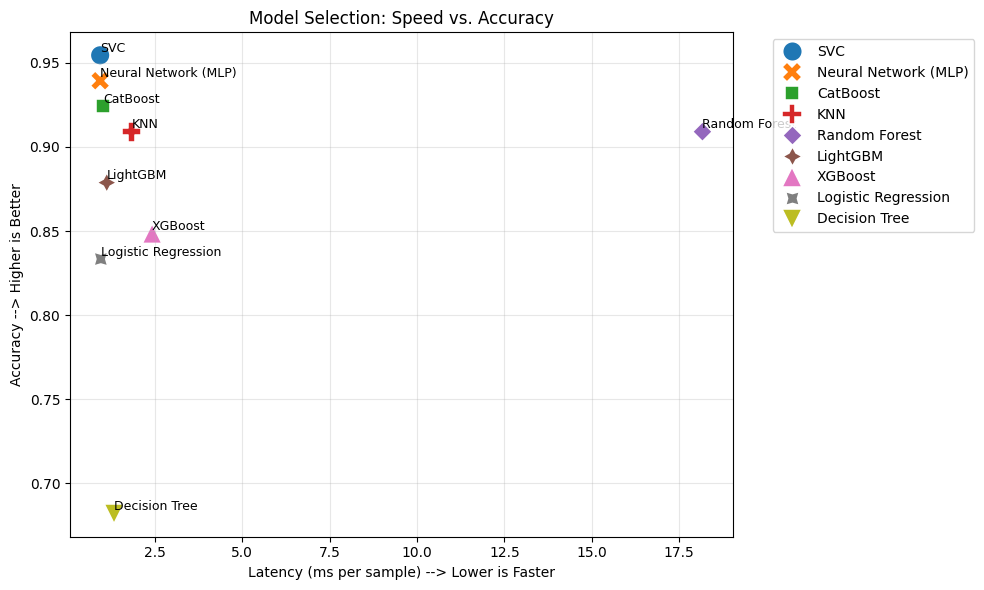

In [19]:
### 16. CLASSIFIER TOURNAMENT & GRID-SEARCH OPTIMIZATION
# Executes a performance tournament across multiple architectures.
# It utilizes GridSearchCV with 5-fold cross-validation to identify the optimal hyperparameters for each model.
# 1. Define Competitors (Grid Search Config)
models_config = [
  {
    "name": "KNN",
    "model": KNeighborsClassifier(),
    # n_neighbors: How many nearby shots to vote? 3, 5, or 7 are standard odd numbers.
    # weights='distance': Closer neighbors count more than far ones.
    "params": {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
  },
  {
    "name": "Logistic Regression",
    "model": LogisticRegression(random_state=42, max_iter=3000, solver='liblinear'),
    # C: Inverse regularization strength. Smaller values specify stronger regularization.
    "params": {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
  },
  {
    "name": "Decision Tree",
    "model": DecisionTreeClassifier(random_state=42),
    "params": {'max_depth': [5, 10, None], 'min_samples_leaf': [1, 4]}
  },
  {
    "name": "Random Forest",
    "model": RandomForestClassifier(random_state=42),
    # A bagging ensemble. Often very robust without much tuning.
    "params": {'n_estimators': [100, 300], 'max_depth': [10, None], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2']}
  },
  {
    "name": "LightGBM",
    "model": LGBMClassifier(random_state=42, verbose=-1),
    # Often faster and sometimes more accurate than XGBoost.
    "params": {'n_estimators': [100, 300], 'learning_rate': [0.05, 0.1], 'num_leaves': [31, 50], 'subsample': [0.8, 1.0]}
  },
  {
    "name": "XGBoost",
    "model": XGBClassifier(random_state=42, eval_metric='mlogloss'),
    # learning_rate=0.1: How fast the model learns. 0.1 is standard.
    # max_depth=3: Prevents overfitting on small data.
    "params": {'n_estimators': [100, 300], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'subsample': [0.8, 1.0]}
  },
  {
    "name": "CatBoost",
    "model": CatBoostClassifier(verbose=0, random_seed=42, thread_count=1, allow_writing_files=False),
    "params": {'iterations': [300, 500], 'depth': [4, 6, 8], 'learning_rate': [0.03, 0.1], 'l2_leaf_reg': [1, 5, 9]}
  },
  {
    "name": "SVC",
    "model": SVC(random_state=42),
    # kernel='rbf': Handles curved decision boundaries (non-linear data).
    # C=10: Strict margin (tries hard not to miss points).
    "params": {'C': [0.1, 1, 10, 100], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto', 0.1, 1]}
   },
   {
    "name": "Neural Network (MLP)",
    "model": MLPClassifier(random_state=42, max_iter=1000),
    # hidden_layer_sizes: (50,) means 1 layer of 50 neurons. (50, 50) is 2 layers.
    # alpha: L2 regularization to prevent overfitting.
    "params": {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.01], 'activation': ['tanh', 'relu']}
   },
   ]

results_data = []
print("\n===  CLASSIFIERS ===")

for config in models_config:
    name = config['name']
    print(f"\n--- Optimizing {config['name']} ---")
    # A. Run Grid Search
    # GridSearchCV: Automatically tries every combination of parameters to find the best one.
    # cv=5: Cross-Validation. Splits training data into 5 parts to verify accuracy multiple times.
    grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_pca, y_train)
    best_model = grid.best_estimator_

    # B. Measure Accuracy
    y_pred = best_model.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)

    # C. Measure Speed
    latency = benchmark_inference_ms(best_model, X_test_pca)

    print(f"Best Params: {grid.best_params_}")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Latency: {latency:.4f} ms/sample")

    # D. Save Results
    results_data.append({
        "Model": name,
        "Accuracy": acc,
        "Latency (ms)": latency,
        "Best Params": grid.best_params_,
        "Model Object": best_model
    })

# Sort by Accuracy (Highest First), then Speed (Lowest First)
df_results = pd.DataFrame(results_data)
df_results = df_results.sort_values(by=["Accuracy", "Latency (ms)"], ascending=[False, True])

print("\n === FINAL LEADERBOARD ===")
print(df_results[["Model", "Accuracy", "Latency (ms)"]].to_string(index=False))

# VISUALIZE: ACCURACY vs. SPEED SCATTER PLOT
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_results, x="Latency (ms)", y="Accuracy", hue="Model", s=200, style="Model")

# Add labels to points
for i, row in df_results.iterrows():
    plt.text(row['Latency (ms)'], row['Accuracy'] + 0.002, row['Model'], fontsize=9)

plt.title("Model Selection: Speed vs. Accuracy")
plt.xlabel("Latency (ms per sample) --> Lower is Faster")
plt.ylabel("Accuracy --> Higher is Better")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# DETAILED REPORT FOR THE WINNER ---
winner_row = df_results.iloc[0]
winner_name = winner_row['Model']
winner_model = winner_row['Model Object']



 THE WINNER IS: SVC
Accuracy: 0.9545
Speed:    0.9383 ms
                     precision    recall  f1-score   support

          The Paint       0.91      0.95      0.93        22
The Free Throw Line       0.95      0.91      0.93        22
   The 3-Point Zone       1.00      1.00      1.00        22

           accuracy                           0.95        66
          macro avg       0.96      0.95      0.95        66
       weighted avg       0.96      0.95      0.95        66

ACCURACY: 0.9545


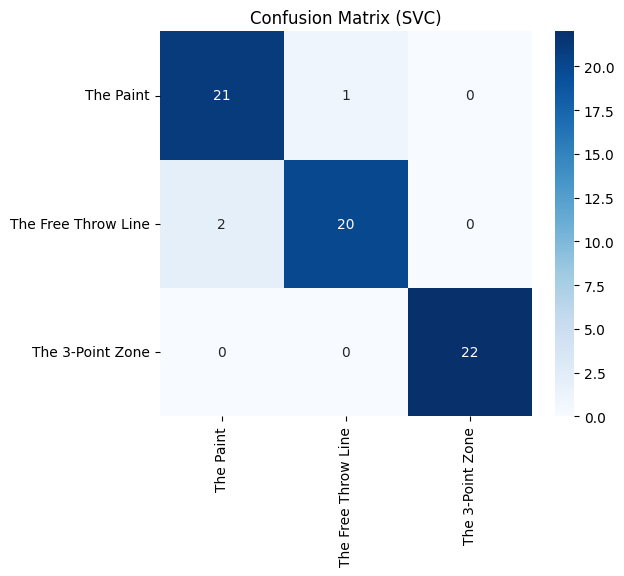

In [20]:
### 17. PERFORMANCE EVALUATION: PRECISION, RECALL, & F1-SCORE
# Generates a detailed classification report for the tournament winner, demonstrating high precision and recall across "The Paint," "Free Throw," and "3-Point" zones.
print(f"\n\n THE WINNER IS: {winner_name}")
print(f"Accuracy: {winner_row['Accuracy']:.4f}")
print(f"Speed:    {winner_row['Latency (ms)']:.4f} ms")

y_pred_final = winner_model.predict(X_test_pca)

if len(y_pred_final.shape) > 1:
     predictions = y_pred_final.flatten()
print(classification_report(y_test, y_pred_final, target_names=['The Paint', 'The Free Throw Line', 'The 3-Point Zone']))

print(f"ACCURACY: {accuracy_score(y_test, y_pred_final):.4f}")

cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['The Paint', 'The Free Throw Line', 'The 3-Point Zone'],
            yticklabels=['The Paint', 'The Free Throw Line', 'The 3-Point Zone'])
plt.title(f"Confusion Matrix ({winner_name})")
plt.show()

In [21]:
### 18. PREDICTION SERIALIZATION & RESULTS EXPORT
# Aligns the final model predictions with subject IDs and ground-truth labels to generate a CSV submission file. This enables external auditing and verification of the classification results.

# Flatten everything to ensure it fits in the CSV
# This prevents the "ValueError: Per-column arrays must be 1-dimensional"
ids_flat = np.array(test_ids).ravel()
true_labels_flat = np.array(test_labels).ravel()
pred_labels_flat = np.array(y_pred_final).ravel()
pred_labels_flat = le_target.inverse_transform(pred_labels_flat.astype(int))

submission = pd.DataFrame({
        'Subject': ids_flat,
        'True_Label': true_labels_flat,
        'Predicted_Label': pred_labels_flat
    })
print(submission.head())

# Save file
filename = f'predictions_{winner_name.replace(" ", "_")}.csv'
submission.to_csv(filename, index=False)
print(f"File '{filename}' saved successfully.")

          Subject        True_Label   Predicted_Label
0  Mohamed_Khaled  The 3-Point Zone  The 3-Point Zone
1  Mohamed_Khaled  The 3-Point Zone  The 3-Point Zone
2           Menna         The Paint         The Paint
3          Nouran  The 3-Point Zone  The 3-Point Zone
4           Mazen         The Paint         The Paint
File 'predictions_SVC.csv' saved successfully.


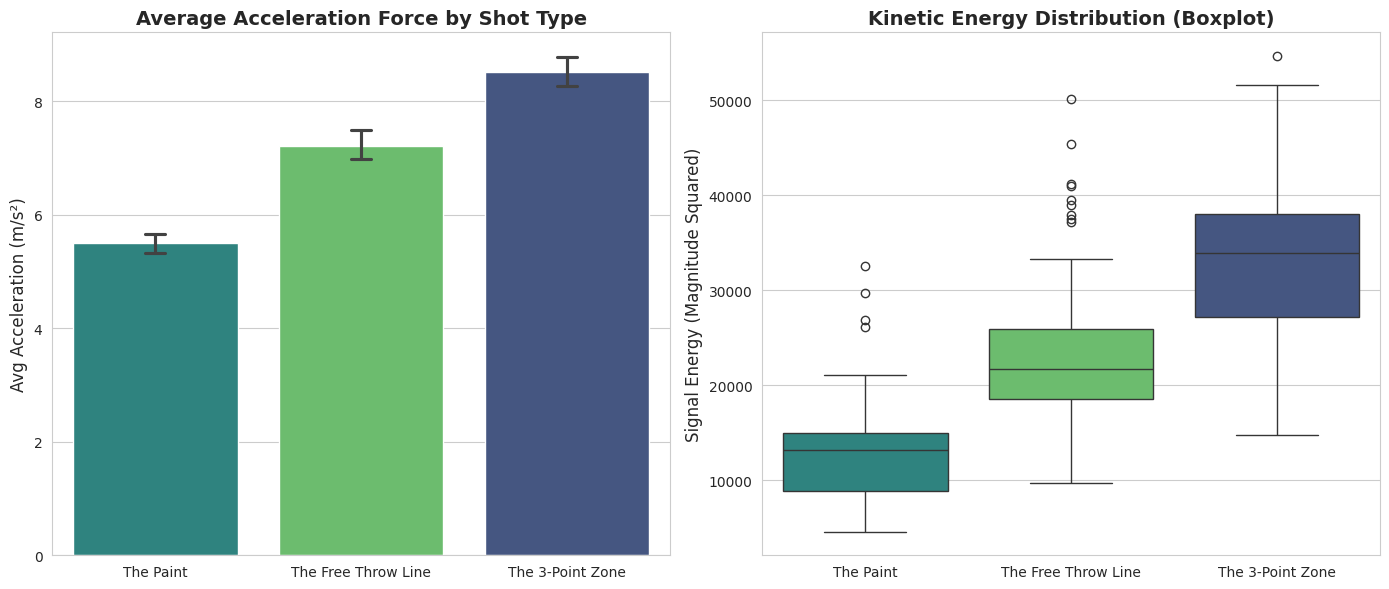

In [22]:
### 19. BIOMECHANICAL PROOF: KINETIC ENERGY & FORCE VALIDATION
# Uses boxplots to visually verify the biomechanical grounding of the data. This step confirms that 3-point shots require significantly higher acceleration and lift energy compared to under-basket shots, proving the dataset follows physical laws.

plot_df = X.copy()

# Check if Label is Text or Number. If Number, decode it correctly.
if np.issubdtype(plot_df['Label'].dtype, np.number):
    plot_df['Label'] = le_target.inverse_transform(plot_df['Label'])

logic_order = ['The Paint', 'The Free Throw Line', 'The 3-Point Zone']

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# --- PLOT 1: AVERAGE ACCELERATION (Force) ---
plt.subplot(1, 2, 1)
sns.barplot(
    x='Label',
    y='mag_mean',
    data=plot_df,
    palette='viridis',
    capsize=0.1,
    hue='Label',
    legend=False,
    order=logic_order
)
plt.title('Average Acceleration Force by Shot Type', fontsize=14, fontweight='bold')
plt.ylabel('Avg Acceleration (m/s²)', fontsize=12)
plt.xlabel('')

# --- PLOT 2: SHOT ENERGY ---
plt.subplot(1, 2, 2)
sns.boxplot(
    x='Label',
    y='mag_energy',
    data=plot_df,
    palette='viridis',
    hue='Label',
    legend=False,
    order=logic_order
)
plt.title('Kinetic Energy Distribution (Boxplot)', fontsize=14, fontweight='bold')
plt.ylabel('Signal Energy (Magnitude Squared)', fontsize=12)
plt.xlabel('')

plt.tight_layout()
plt.show()

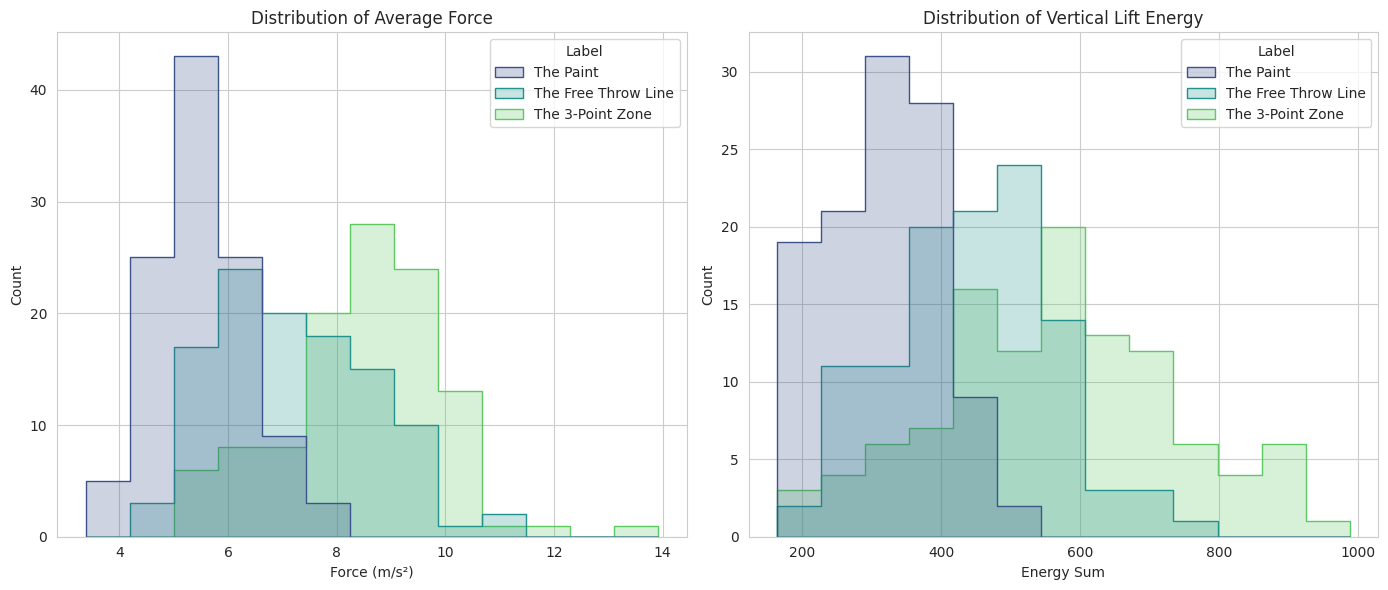

In [23]:
### 20. DISTRIBUTIVE ANALYSIS (FEATURE HISTOGRAMS)
# Visualizes the distribution of average force and vertical lift energy across different shot labels to verify class separability.

plt.figure(figsize=(14, 6))

# Histogram 1: Max Force
plt.subplot(1, 2, 1)
sns.histplot(
    data=plot_df,
    x='mag_mean',
    hue='Label',
    element="step",
    common_norm=False,
    hue_order=logic_order,
    palette='viridis'
)
plt.title("Distribution of Average Force")
plt.xlabel("Force (m/s²)")

# Histogram 2: Vertical Energy
plt.subplot(1, 2, 2)
sns.histplot(
    data=plot_df,
    x='Vertical Lift Energy',
    hue='Label',
    element="step",
    common_norm=False,
    hue_order=logic_order,
    palette='viridis'
)
plt.title("Distribution of Vertical Lift Energy")
plt.xlabel("Energy Sum")

plt.tight_layout()
plt.show()

In [24]:
### 21. GLOBAL FEATURE IMPORTANCE RANKING
# Uses a CatBoost-based inspector to rank every physical marker by its mathematical influence on the final classification results.
# 1. Train a quick Inspector Model (CatBoost is best for this)
# We use X_train (which still has column names) and y_train (encoded labels)
inspector = CatBoostClassifier(iterations=500, verbose=0, random_seed=42)
inspector.fit(X_train, y_train)

# 2. Extract Importance
importances = inspector.get_feature_importance()
feature_names = X_train.columns

# 3. Create Ranking Table
ranking = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. Print ALL rows
pd.set_option('display.max_rows', None)
print("\n=== FULL FEATURE IMPORTANCE RANKING ===")
print(ranking)
pd.reset_option('display.max_rows') # Reset setting


=== FULL FEATURE IMPORTANCE RANKING ===
                     Feature  Importance
243               mag_energy    5.629629
7      Avg Smoothness (Jerk)    4.779090
221        earth_acc_y_range    4.386030
195                pitch_max    3.802882
241                  mag_max    3.392066
100               grav_y_min    2.361565
5      Normalized Lift Force    2.110981
230          earth_acc_z_std    1.934195
183            ori_pitch_max    1.889053
148                ori_x_min    1.761174
242                 mag_mean    1.495296
219          earth_acc_y_max    1.481941
210          earth_acc_x_rms    1.382737
215     earth_acc_x_spec_ent    1.351696
222          earth_acc_y_rms    1.349887
235       earth_acc_z_energy    1.337958
47            acc_x_spec_ent    1.331329
40                 acc_x_min    1.302066
159               ori_qw_max    1.269740
136                ori_y_min    1.259344
240     earth_acc_z_dom_freq    1.184264
18                 acc_z_rms    1.106335
141             